In [1]:
# MUST be the first cell in the notebook
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import sys
from utils import load_it_data, visualize_img, compute_ev_and_corr
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [2]:
def set_seed(seed=0):
    print('Deterministic code, set seed to', seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 6
set_seed(seed=seed)

Deterministic code, set seed to 6


In [3]:
import sys
!{sys.executable} -m pip install gdown h5py

In [4]:
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=652e9991-6fc4-4918-b2b8-0097f770ba51
To: /content/IT_data.h5
100%|██████████| 384M/384M [00:02<00:00, 137MB/s]


'IT_data.h5'

## Load the data

In [5]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [6]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


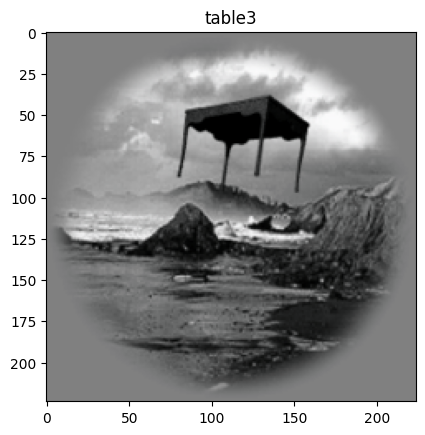

In [7]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

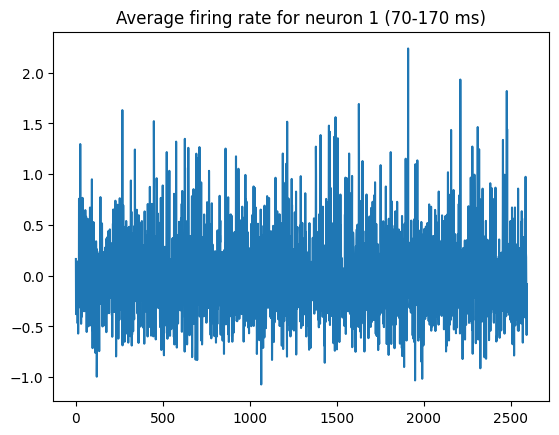

In [8]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

In [9]:
class ITNeuralActivity(Dataset):
    def __init__(self, X, y=None, transform=None):
        """
        Custom Dataset for IT neural activity prediction.

        Args:
            X (numpy array): Input stimuli (e.g., images).
            y (numpy array, optional): Neural activity (e.g., spikes). Default is None for test data.
            transform (callable, optional): Optional transform to be applied on the input stimuli.
        """
        self.X = X
        self.y = torch.from_numpy(y).float() if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        neural_activity = self.y[idx] if self.y is not None else None

        if self.transform:
            img = self.transform(torch.from_numpy(img).float())

        return (img, neural_activity) if neural_activity is not None else img


# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the model (DeepNet201)

In [10]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet‑pretrained backbone
backbone = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone.classifier = nn.Linear(in_features, n_neurons)

model = backbone.cuda()
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 18,415,656


## Define the loss function and the optimizer

In [11]:
import torch.optim as optim

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
def train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device='cpu', scheduler=None):
    """
    Train the model and validate it after each epoch.

    Args:
        model (nn.Module): The neural network model.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        loss_function (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        epochs (int): Number of training epochs.

    Returns:
        None
    """
    model.to(device)

    # Learning rate scheduler
    if scheduler is None:
        # Use StepLR scheduler with step size of 5 and gamma of 0.1
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, spikes in train_dataloader:
            images, spikes = images.to(device), spikes.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, spikes)

            # Backward pass & optimization
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, spikes in val_dataloader:
                images, spikes = images.to(device), spikes.to(device)

                # Forward pass
                outputs = model(images)
                loss = loss_function(outputs, spikes)

                val_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader):.4f}, "
              f"Val Loss: {val_loss/len(val_dataloader):.4f}")

        # Stop training if loss becomes NaN or Inf
        if torch.isnan(torch.tensor(train_loss)) or torch.isinf(torch.tensor(train_loss)):
            print("Training stopped due to unstable loss (NaN or Inf).")
            break

In [13]:
#Uses original scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.1146, Val Loss: 0.0969
Epoch 2/15, Train Loss: 0.0878, Val Loss: 0.0874
Epoch 3/15, Train Loss: 0.0781, Val Loss: 0.0848
Epoch 4/15, Train Loss: 0.0713, Val Loss: 0.0748
Epoch 5/15, Train Loss: 0.0657, Val Loss: 0.0802
Epoch 6/15, Train Loss: 0.0520, Val Loss: 0.0614
Epoch 7/15, Train Loss: 0.0475, Val Loss: 0.0603
Epoch 8/15, Train Loss: 0.0452, Val Loss: 0.0600
Epoch 9/15, Train Loss: 0.0437, Val Loss: 0.0607
Epoch 10/15, Train Loss: 0.0411, Val Loss: 0.0596
Epoch 11/15, Train Loss: 0.0384, Val Loss: 0.0591
Epoch 12/15, Train Loss: 0.0379, Val Loss: 0.0592
Epoch 13/15, Train Loss: 0.0368, Val Loss: 0.0593
Epoch 14/15, Train Loss: 0.0368, Val Loss: 0.0592
Epoch 15/15, Train Loss: 0.0363, Val Loss: 0.0591


## Evaluate the prediction of the model

In [14]:
def evaluate_model(model, dataloader, spikes_val, device='cpu'):
    """
    Evaluate the model using explained variance and correlation.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        spikes_val (numpy array): Ground truth neural activity for validation.
        loss_function (nn.Module, optional): Loss function (if needed for logging).
        device (str): Device to evaluate on ('cpu' or 'cuda').

    Returns:
        None
    """
    model.to(device)
    model.eval()

    # Compute explained variance & correlation
    overall_ev, overall_corr, ev_per_neuron, corr_per_neuron = compute_ev_and_corr(model, dataloader, spikes_val)

    print(f'Overall explained variance: {overall_ev:.4f}')
    print(f'Overall correlation: {overall_corr:.4f}')

    # Plot histograms for explained variance & correlation
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].hist(ev_per_neuron, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axs[0].set_title('Explained Variance per Neuron')
    axs[0].set_xlabel('Explained Variance')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(corr_per_neuron, bins=20, color='green', alpha=0.7, edgecolor='black')
    axs[1].set_title('Correlation per Neuron')
    axs[1].set_xlabel('Correlation Coefficient')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

Overall explained variance: 0.4902
Overall correlation: 0.6897


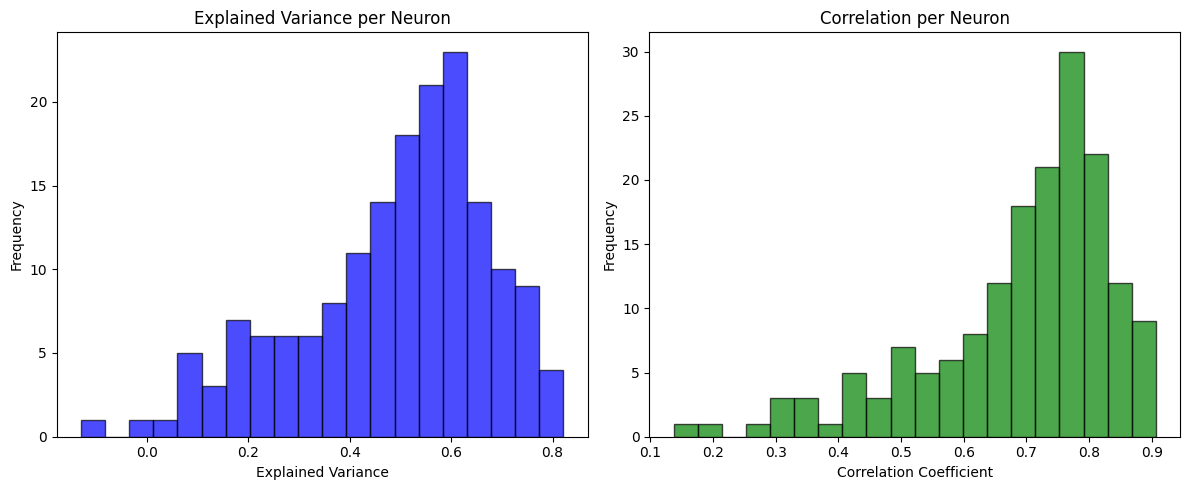

In [15]:
# Evaluate model on the validation set
evaluate_model(model, val_dataloader, spikes_val, device="cpu")

### Define a new model (ResNet‑152)

In [16]:
from torchvision.models import resnet152, ResNet152_Weights

# load ImageNet‑pretrained ResNet‑152 (pre‑activation = "v2")
backbone = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

# swap the 1000‑way classifier for NUM_NEURONS regression head
in_features = backbone.fc.in_features          # 2048
backbone.fc = nn.Linear(in_features, n_neurons)

model2 = backbone.cuda()
print(f"ResNet‑152 params: {sum(p.numel() for p in model2.parameters()):,}")


ResNet‑152 params: 58,488,040


In [17]:
import torch.optim as optim

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

In [18]:
#Uses original scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model2, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.1035, Val Loss: 0.0925
Epoch 2/15, Train Loss: 0.0784, Val Loss: 0.0793
Epoch 3/15, Train Loss: 0.0652, Val Loss: 0.0755
Epoch 4/15, Train Loss: 0.0557, Val Loss: 0.0682
Epoch 5/15, Train Loss: 0.0472, Val Loss: 0.0673
Epoch 6/15, Train Loss: 0.0367, Val Loss: 0.0600
Epoch 7/15, Train Loss: 0.0311, Val Loss: 0.0598
Epoch 8/15, Train Loss: 0.0280, Val Loss: 0.0598
Epoch 9/15, Train Loss: 0.0253, Val Loss: 0.0601
Epoch 10/15, Train Loss: 0.0227, Val Loss: 0.0606
Epoch 11/15, Train Loss: 0.0199, Val Loss: 0.0604
Epoch 12/15, Train Loss: 0.0195, Val Loss: 0.0606
Epoch 13/15, Train Loss: 0.0192, Val Loss: 0.0605
Epoch 14/15, Train Loss: 0.0189, Val Loss: 0.0608
Epoch 15/15, Train Loss: 0.0186, Val Loss: 0.0609


Overall explained variance: 0.4727
Overall correlation: 0.6810


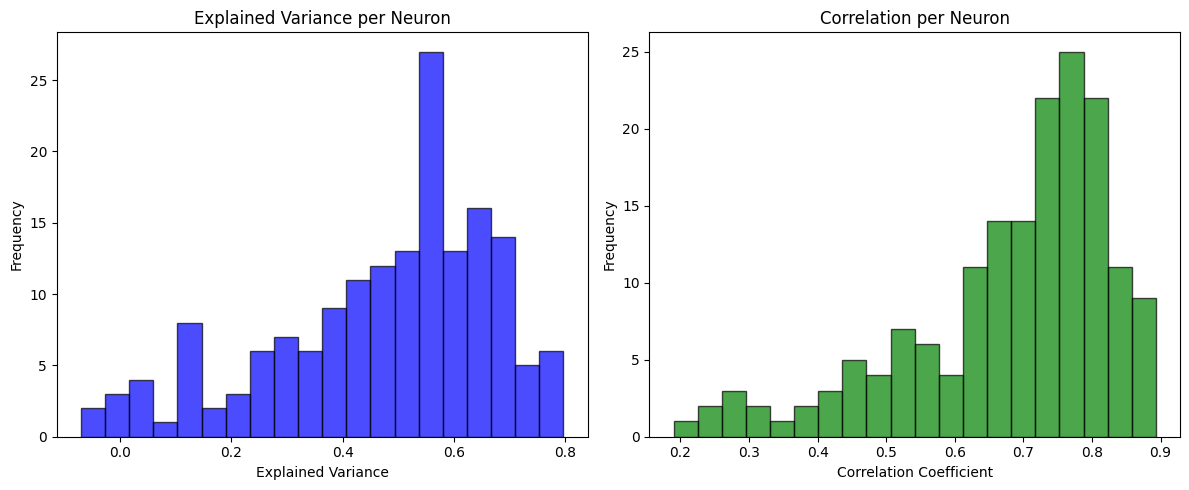

In [19]:
# Evaluate model on the validation set
evaluate_model(model2, val_dataloader, spikes_val, device="cpu")

## Define a new model (pnasnet5large)

In [20]:
# ------------------------------------------------------------------
#  PNASNet‑5 Large backbone pretrained on ImageNet‑1k
# ------------------------------------------------------------------
import timm, torch.nn as nn

backbone = timm.create_model("pnasnet5large", pretrained=True)

# ------------------------------------------------------------------
#  Replace the ImageNet head with a NUM_NEURONS regression head
#     timm models use different attribute names, so check in order
# ------------------------------------------------------------------
if hasattr(backbone, "classifier"):          # many EfficientNet‑style models
    in_features = backbone.classifier.in_features
    backbone.classifier = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "fc"):                # ResNet‑style
    in_features = backbone.fc.in_features
    backbone.fc = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "head"):              # ViT / ConvNeXt‑style
    in_features = backbone.head.in_features
    backbone.head = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "last_linear"):       # Inception / PNASNet
    in_features = backbone.last_linear.in_features
    backbone.last_linear = nn.Linear(in_features, n_neurons)
else:
    raise AttributeError("Cannot locate final classifier layer.")

model3 = backbone.cuda()
print(f"PNASNet‑5 Large parameters: {sum(p.numel() for p in model3.parameters()):,}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


PNASNet‑5 Large parameters: 82,462,596


In [21]:
optimizer = optim.Adam(model3.parameters(), lr=learning_rate)

In [22]:
#Uses original scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model3, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.1208, Val Loss: 0.1185
Epoch 2/15, Train Loss: 0.0990, Val Loss: 0.0936
Epoch 3/15, Train Loss: 0.0862, Val Loss: 0.0847
Epoch 4/15, Train Loss: 0.0781, Val Loss: 0.0794
Epoch 5/15, Train Loss: 0.0711, Val Loss: 0.0791
Epoch 6/15, Train Loss: 0.0630, Val Loss: 0.0690
Epoch 7/15, Train Loss: 0.0595, Val Loss: 0.0679
Epoch 8/15, Train Loss: 0.0569, Val Loss: 0.0674
Epoch 9/15, Train Loss: 0.0549, Val Loss: 0.0664
Epoch 10/15, Train Loss: 0.0525, Val Loss: 0.0658
Epoch 11/15, Train Loss: 0.0497, Val Loss: 0.0653
Epoch 12/15, Train Loss: 0.0489, Val Loss: 0.0652
Epoch 13/15, Train Loss: 0.0488, Val Loss: 0.0653
Epoch 14/15, Train Loss: 0.0482, Val Loss: 0.0651
Epoch 15/15, Train Loss: 0.0477, Val Loss: 0.0650


Overall explained variance: 0.4585
Overall correlation: 0.6640


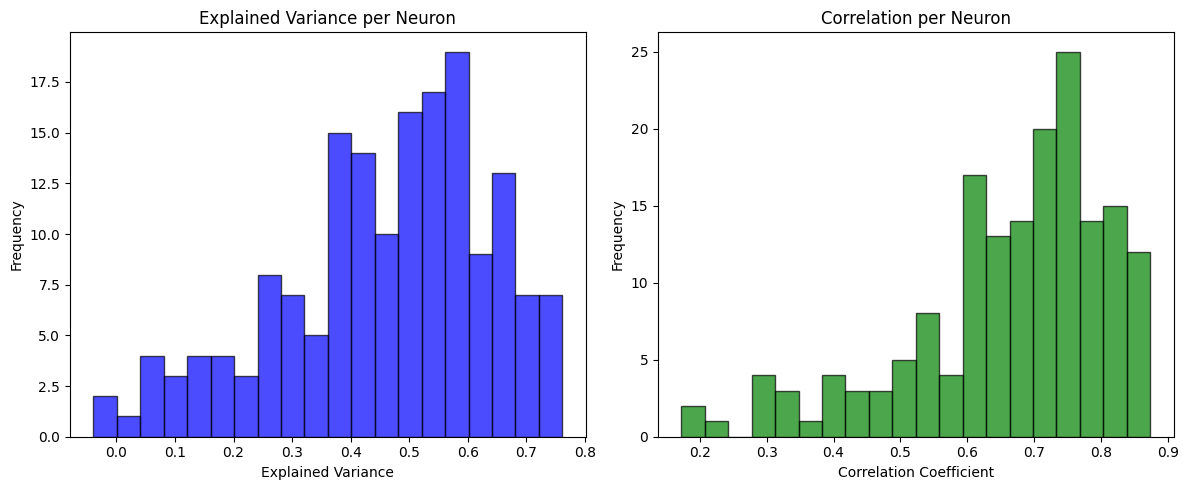

In [23]:
# Evaluate model on the validation set
evaluate_model(model3, val_dataloader, spikes_val, device="cpu")

## Define a new model (vit_large_patch14_clip_224)

In [24]:
import timm, torch.nn as nn

MODEL_NAME = "vit_large_patch14_clip_224"   # pick one of the three
backbone   = timm.create_model(MODEL_NAME, pretrained=True)

# universal head‑swap
for attr in ["classifier", "fc", "head", "last_linear"]:
    if hasattr(backbone, attr):
        in_features = getattr(backbone, attr).in_features
        setattr(backbone, attr, nn.Linear(in_features, n_neurons))
        break
else:
    raise AttributeError("Could not locate classifier head.")

model4 = backbone.cuda()

print(f"PNASNet‑5 Large parameters: {sum(p.numel() for p in model4.parameters()):,}")


PNASNet‑5 Large parameters: 303,351,976


In [25]:
optimizer = optim.Adam(model4.parameters(), lr=learning_rate)

In [26]:
#Uses original scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model4, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.1722, Val Loss: 0.1449
Epoch 2/15, Train Loss: 0.1378, Val Loss: 0.1416
Epoch 3/15, Train Loss: 0.1361, Val Loss: 0.1398
Epoch 4/15, Train Loss: 0.1352, Val Loss: 0.1380
Epoch 5/15, Train Loss: 0.1339, Val Loss: 0.1391
Epoch 6/15, Train Loss: 0.1311, Val Loss: 0.1353
Epoch 7/15, Train Loss: 0.1293, Val Loss: 0.1339
Epoch 8/15, Train Loss: 0.1284, Val Loss: 0.1335
Epoch 9/15, Train Loss: 0.1271, Val Loss: 0.1331
Epoch 10/15, Train Loss: 0.1257, Val Loss: 0.1307
Epoch 11/15, Train Loss: 0.1233, Val Loss: 0.1302
Epoch 12/15, Train Loss: 0.1224, Val Loss: 0.1298
Epoch 13/15, Train Loss: 0.1219, Val Loss: 0.1300
Epoch 14/15, Train Loss: 0.1215, Val Loss: 0.1296
Epoch 15/15, Train Loss: 0.1212, Val Loss: 0.1297


Overall explained variance: 0.0724
Overall correlation: 0.2584


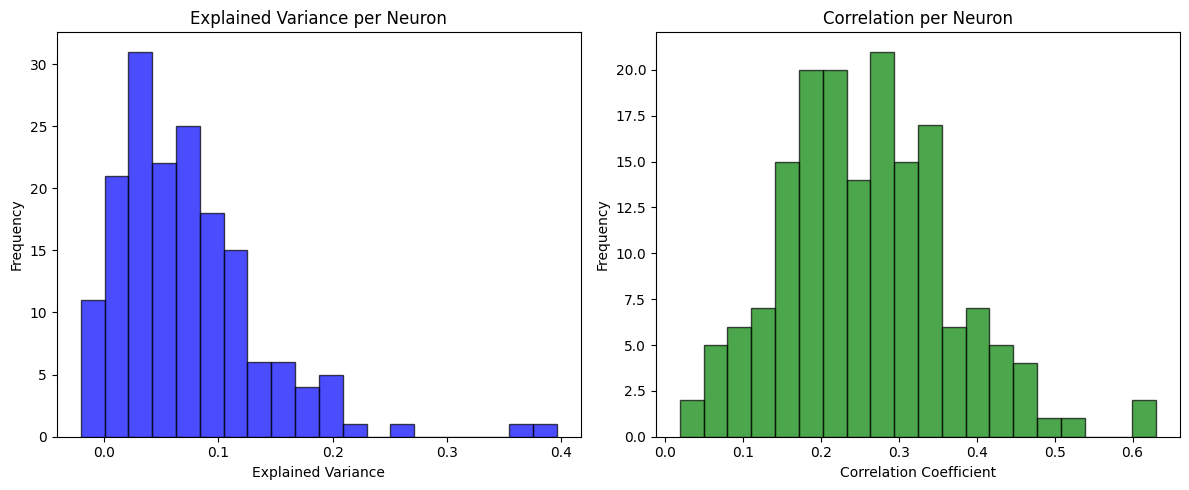

In [27]:
# Evaluate model on the validation set
evaluate_model(model4, val_dataloader, spikes_val, device="cpu")